In [ ]:
!pip3 install -q git+git://github.com/arviz-devs/arviz.git
!pip install "arviz[all]"
# !pip3 install --upgrade tensorflow-probability
!pip install colorcet
!pip install seaborn

In [3]:
from pprint import pprint
import matplotlib.pyplot as plt
import colorcet as cc
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

create grid of parameters for every location  
MxN grid matching fire map  
MxNx3 where each channel is data-point  
Starting off with baseline model (proximity to fire-point)

In [4]:
# treating as ground truth
fire = np.zeros((10, 15))

# uniform for prior 
uniforms = tfd.Uniform([0.5, 0.5, 0.5])
prior = tf.ones(shape=(10, 15))/2

uniforms.sample(10)

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.84022886, 0.54673624, 0.77764857],
       [0.508799  , 0.9002625 , 0.70757705],
       [0.9330821 , 0.8374257 , 0.8960349 ],
       [0.5868667 , 0.597997  , 0.9946963 ],
       [0.90322435, 0.8328464 , 0.9975814 ],
       [0.63318616, 0.617     , 0.9265699 ],
       [0.98078173, 0.81471044, 0.9823448 ],
       [0.7997662 , 0.8649959 , 0.5623276 ],
       [0.9928872 , 0.83983034, 0.5940608 ],
       [0.7888879 , 0.7570533 , 0.703988  ]], dtype=float32)>

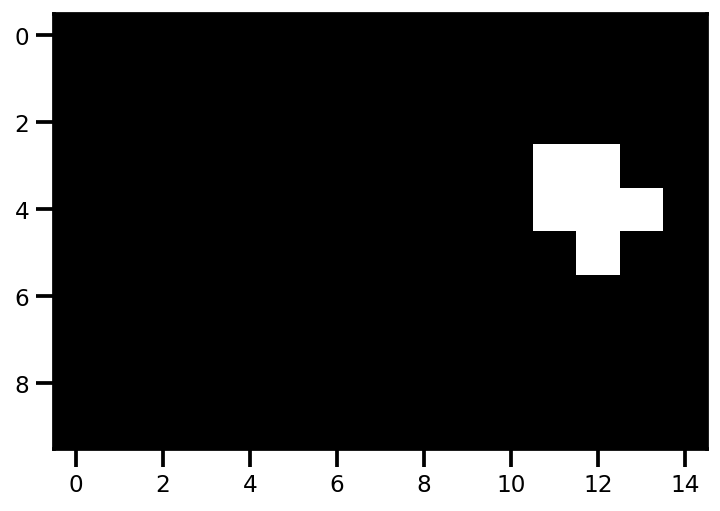

In [25]:
# filling in fire information
# This array represents what pixels are currently on fire fromt the MODIS firemask

fire[3, 12] = 1
fire[4, 12] = 1
fire[5, 12] = 1
fire[4, 13] = 1
fire[4, 11] = 1
fire[3, 11] = 1
fire[3, 12] = 1

plt.imshow(fire, cmap='gray')

figure out for how to do for single point, then scale up  
this is **not** a time-series problem, aim is to learn $P(\theta)$, which translates to a Bayesian Regression  
point would have:
- $\theta$ for prior probability  
- Vector holding: distance to nearest fire-point, etc

Aim is to derive relationship for $P(\theta|\text{Actual Data for All Actual Data})$, put a little less vaguely (for each data point, subscript for theta indexing spatially omitted since this is not a spatial problem either):  
$$
P(\theta_{t}|\overrightarrow{y_t},\theta_{t-1})
$$

In [14]:
y, rv_y = [0, 100,-5], tfd.Normal(0, 1)

negloklik = lambda y, rv_y: -rv_y.log_prob(y)
tf.print(negloklik(y, rv_y))

[0.918938518 5000.91895 13.4189386]
